# Display of products and saving in fits format using api.plot_tools

This notebooks documents the functinality of oda_api.plot_tools to visualize images, spectra, and light curves.

Each of these products can also be saved in fits format. The user can add systematic uncertainty to the light curves and spectra; the latter can also be grouped for a quicker fit at the moment of saving files.

Utilities to extract a manipulate the image catalog are also given in order to optimize spectral and 
light curve extraction.

author Carlo Ferrigno (carlo.ferrigno@unige.ch)

In [67]:
source_name="GX 1+4"
tstart='2019-01-01T00:00:00'
tstop='2019-03-31T23:59:59'
n_scw_ima = 10
n_scw_spec_lc = 20
radius_isgri = 8
radius_j1 = 3
run_spec=True
make_image=True
make_j1_image=True
make_lc=True
run_lc_jemx1 = True
e_min = 28.
e_max = 50.
e_min_j1 = 3.
e_max_j1 = 20.
#Note that some of these parameters should be tags for the gallery

In [2]:
from importlib import reload

In [3]:
import logging
#logging.getLogger().setLevel(logging.WARNING)
logging.getLogger().setLevel(logging.INFO) #for more verbose logging

logging.getLogger('').addHandler(logging.StreamHandler()) 

In [4]:
import os,sys
lib_path=os.path.abspath('/home/ferrigno/Soft/oda_api')
if lib_path not in sys.path:
    sys.path.append(lib_path)
else:
    print("Not appending")
import oda_api

## Get the token

In [5]:
import oda_api.token
token = oda_api.token.discover_token()
oda_api.token.decode_oda_token(token)

decoding token with jwt and NOT verifying
found token in environment variable ODA_TOKEN your token payload: {
    "email": "Carlo.Ferrigno@unige.ch",
    "exp": 1638890893,
    "name": "cferrigno",
    "roles": "authenticated user, administrator, user manager, content manager, general, integral-private-qla, magic, unige-hpc-full, public-pool-hpc, antares, sdss",
    "sub": "Carlo.Ferrigno@unige.ch"
}
token expires in 291.1 h
decoding token with jwt and NOT verifying


{'sub': 'Carlo.Ferrigno@unige.ch',
 'email': 'Carlo.Ferrigno@unige.ch',
 'name': 'cferrigno',
 'roles': 'authenticated user, administrator, user manager, content manager, general, integral-private-qla, magic, unige-hpc-full, public-pool-hpc, antares, sdss',
 'exp': 1638890893}

In [11]:
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord


simbad = Simbad.query_object(source_name)
coord = SkyCoord(simbad['RA'], simbad['DEC'], unit=[u.hour, u.deg])
coord.fk5

#coord = SkyCoord(ra,dec, unit=[u.deg, u.deg])
ra = coord.ra.deg
dec = coord.dec.deg
print("Coordinates for %s are RA=%.4f, Dec=%.4f"%(source_name,ra,dec ) )

Coordinates for GX 1+4 are RA=263.0090, Dec=-24.7456


## We make an image

In [30]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_ima,
"detection_threshold": "7.0",
"instrument": "isgri",
"integral_data_rights": "public",
"oda_api_version": "1.1.22",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "isgri_image",
"product_type": "Real",

}

In [31]:
import oda_api.api
host="https://www.astro.unige.ch/mmoda/dispatch-data"

disp = oda_api.api.DispatcherAPI(url=host)

if make_image:
    
    isgri_image=disp.get_product(**par_dict)


/home/ferrigno/Soft/oda_api/oda_api/api.py:891: UserWarning: 
----------------------------------------------------------------------------
the parameter: oda_api_version   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'E1_keV', 'E2_keV', 'detection_threshold', 'image_scale_min', 'image_scale_max']
this will throw an error in a future version 
and might break the current request!
 ----------------------------------------------------------------------------

  warnings.warn(msg)
- waiting for remote response (since 2021-11-25 13:55:42), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: I0IZAET3AMLJJ39B job: aed97c268654ca54

... query status prepared => done
... assigned job id: aed97c268654ca54
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


In [32]:
%matplotlib notebook

## We can look at the image and use sliders to adjust the contrast

<IPython.core.display.Javascript object>


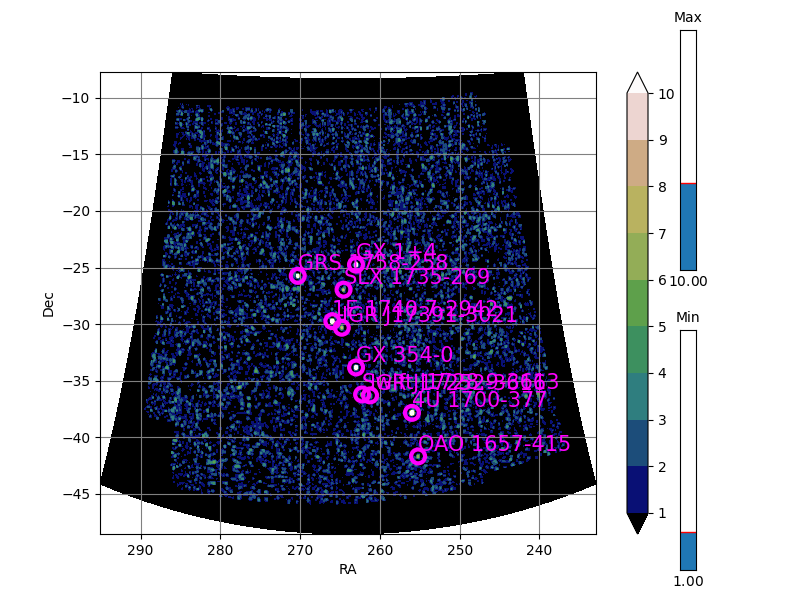

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58526.447905 from DATE-OBS.
Set MJD-END to 58557.991262 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58526.447905 from DATE-OBS.
Set MJD-END to 58557.991262 from DATE-END'.
/home/ferrigno/Soft/oda_api/oda_api/plot_tools.py:109: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_earth").copy()
  plt.xlim([ra.max(), ra.min()])


In [33]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(isgri_image)
_=image.show()

## We get the catalog from the image to be used in the light curves and spectra
- note that we can add an object of interest in the case it is not detected in the mosaic and to assign a FLAG=1
- Coordinates are derived from Simbad, or dirctly given as objects_of_interest=[(source_name, coord)], see above for the coord definition

In [58]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(isgri_image)
catalog_string = image.extract_catalog_string_from_image(objects_of_interest=[source_name])

Elaborating object of interest: GX 1+4 263.008977 -24.745590
RA=263.009 Dec=-24.7456
Found GX 1+4 in catalog


In [39]:
catalog_string

'{"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[3, 20, 46, 47, 54, 128, 150, 245, 262, 277], ["1E 1740.7-2942", "4U 1700-377", "GRS 1758-258", "GX 1+4", "GX 354-0", "IGR J17252-3616", "IGR J17391-3021", "OAO 1657-415", "SLX 1735-269", "Swift J1728.9-3613"], [37.77094268798828, 35.79611587524414, 23.00543785095215, 38.75000762939453, 33.56985092163086, 7.799460411071777, 8.421113014221191, 8.176356315612793, 8.559125900268555, 9.243657112121582], [265.9716796875, 255.99024963378906, 270.3056640625, 263.0048828125, 262.99346923828125, 261.2395935058594, 264.7843322753906, 255.21841430664062, 264.5645751953125, 262.23870849609375], [-29.741472244262695, -37.84401321411133, -25.738916397094727, -24.74757957458496, -33.83165740966797, -36.302249908447266, -30.321863174438477, -41.690799713134766, -26.958356857299805, -36.21576690673828], [-32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768], [2, 2, 2, 2, 2, 1, 2, 2, 2, 2], [0, 0, 0, 1, 0, 0, 0

## We make an imag for JEM-X1 and visualize it

In [68]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_ima,
"jemx_num": "1",
"osa_version": "OSA11.1",
"detection_threshold": "7.0",
"integral_data_rights": "public",
"instrument": "jemx",
"product": "jemx_image",
"product_type": "Real",
"off_line": "False",
}

In [69]:
reload(oda_api)
disp = oda_api.api.DispatcherAPI(url=host)

if make_j1_image:
    
    j1_image=disp.get_product(**par_dict)
        


- waiting for remote response (since 2021-11-25 16:16:03), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: ZV3OYMCHXWQT5AUN job: d54647bb70eef4b9

... query status prepared => done
... assigned job id: d54647bb70eef4b9
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


<IPython.core.display.Javascript object>


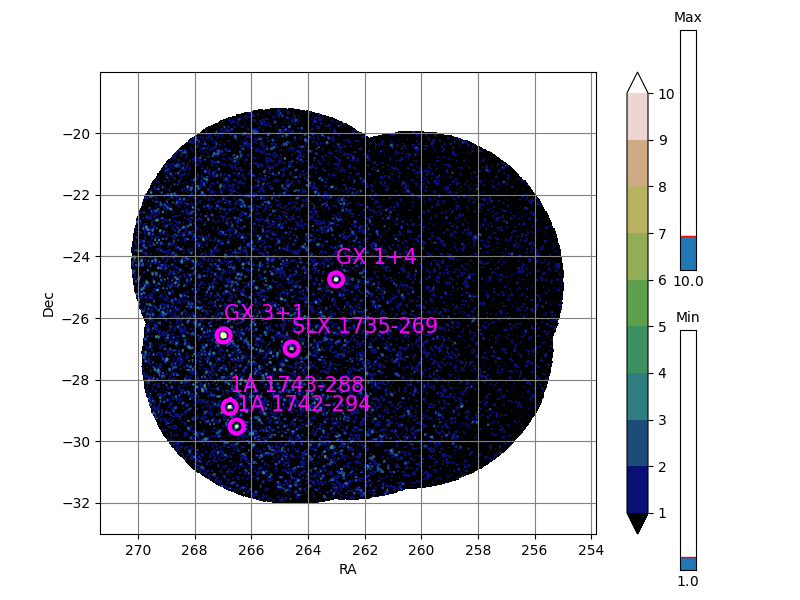

In [73]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(j1_image)
_=image.show()

## We can write the image in a fits file

In [74]:
reload(oda_api.plot_tools)
image = oda_api.plot_tools.OdaImage(j1_image)
image.write_fits('J1_')

## We can make a light curve and simply visualize it
(note that we use the catalog extracted from the image)

In [55]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "isgri",
"integral_data_rights": "public",
"osa_version": "OSA11.1",
"product": "isgri_lc",
"product_type": "Real",
"time_bin": "1000",
"token": token,
"selected_catalog": catalog_string
}


In [56]:
reload(oda_api)
disp = oda_api.api.DispatcherAPI(url=host)
if make_lc:

    combined_data=disp.get_product(**par_dict)
        
        

- waiting for remote response (since 2021-11-25 15:56:08), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: 7O4Z0W68LJLOMF6H job: 939e2f6a95be408e

... query status prepared => done
... assigned job id: 939e2f6a95be408e
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


<IPython.core.display.Javascript object>


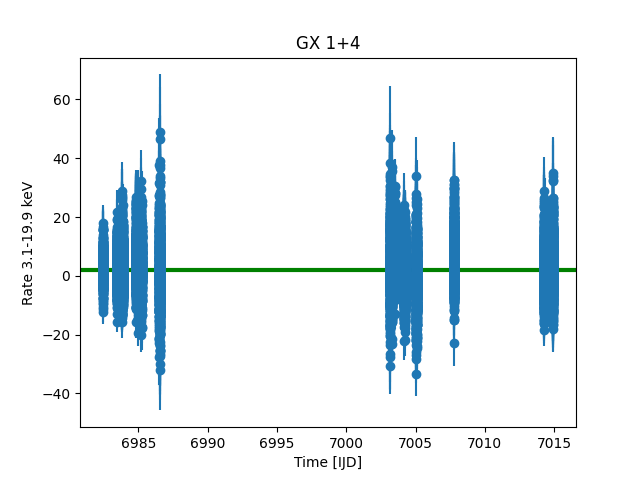

In [89]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
lc = oda_api.plot_tools.OdaLightCurve(combined_data)
_=lc.show(source_name)

## If no source is given all light curves are shown

<IPython.core.display.Javascript object>


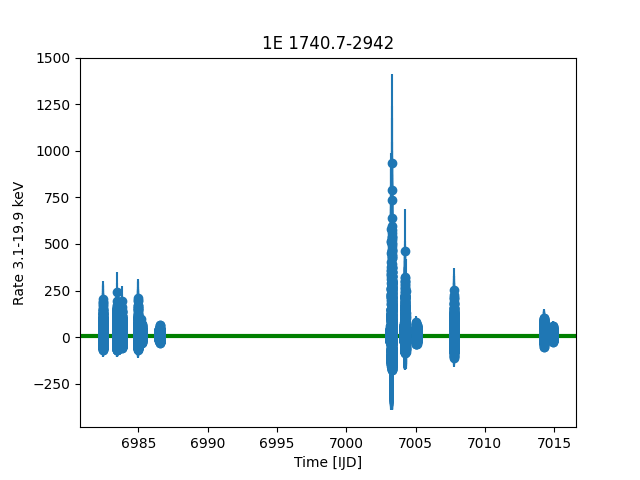

<IPython.core.display.Javascript object>


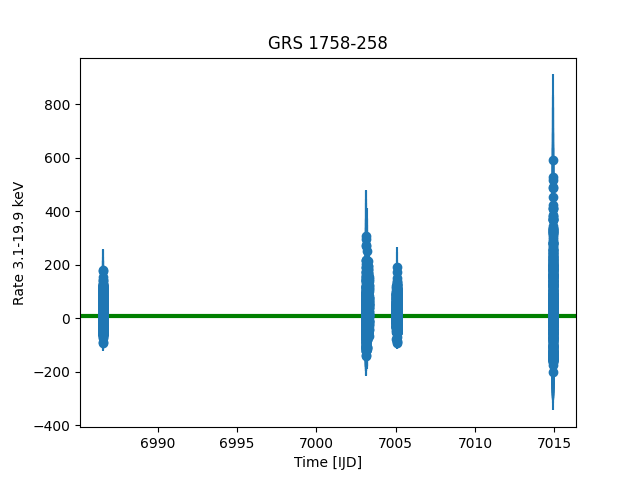

<IPython.core.display.Javascript object>


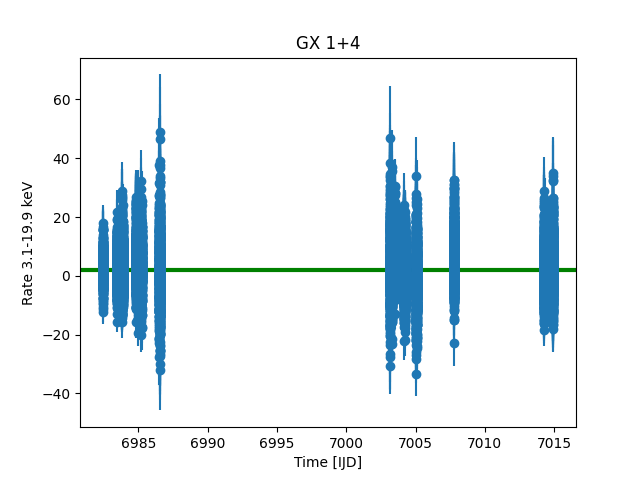

<IPython.core.display.Javascript object>


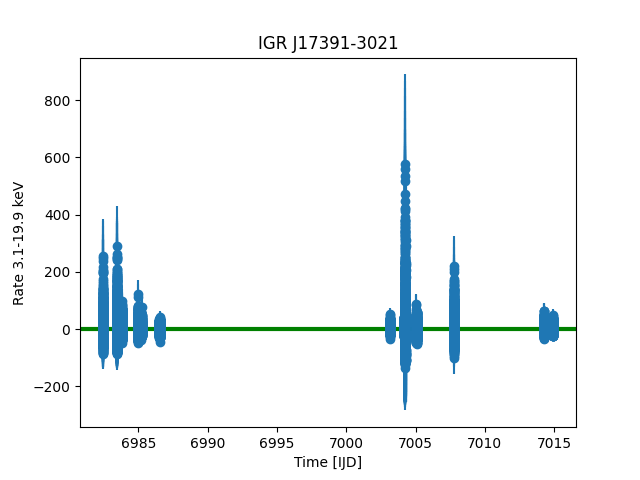

<IPython.core.display.Javascript object>


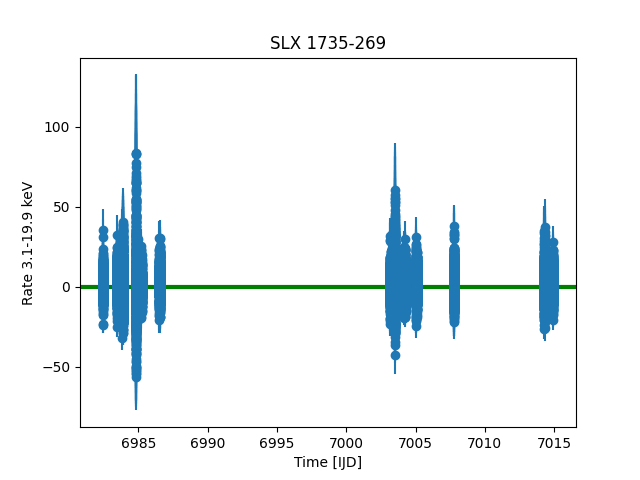

In [90]:
_=lc.show()

## We can search for thermonuclear bursts in the JEM-X light curve

In [59]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "jemx",
"integral_data_rights": "public",
"jemx_num": "1",
"oda_api_version": "1.1.22",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "jemx_lc",
"product_type": "Real",
"selected_catalog": catalog_string,
"src_name": "1E 1740.7-2942",
"time_bin": "4",
"token": token}

In [60]:
if run_lc_jemx1 :
    
    disp = oda_api.api.DispatcherAPI(url=host)
        
    combined_data=disp.get_product(**par_dict)


/home/ferrigno/Soft/oda_api/oda_api/api.py:891: UserWarning: 
----------------------------------------------------------------------------
the parameter: oda_api_version   is not among valid ones:
['src_name', 'RA', 'DEC', 'T1', 'T2', 'token', 'scw_list', 'selected_catalog', 'radius', 'max_pointings', 'osa_version', 'integral_data_rights', 'jemx_num', 'E1_keV', 'E2_keV', 'time_bin']
this will throw an error in a future version 
and might break the current request!
 ----------------------------------------------------------------------------

  warnings.warn(msg)
- waiting for remote response (since 2021-11-25 16:01:36), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: FA48E2LCWRXX0YJ5 job: 6925787c7551a55e

... query status prepared => done
... assigned job id: 6925787c7551a55e
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


## Advanced display of light curves
- with the keyword ng_sig_limit you can select the limit for variability in standard deviations
- with the keyword find_excesses you can find points above this limit, which can be useful to find thermonuclear bursts 

<IPython.core.display.Javascript object>


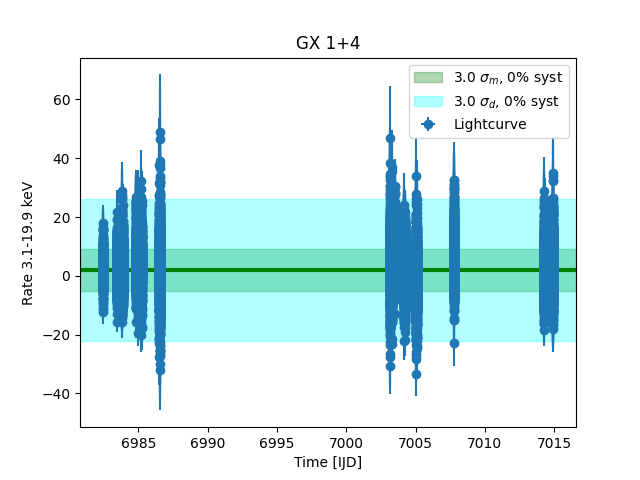

In [61]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
lc = oda_api.plot_tools.OdaLightCurve(combined_data)
_=lc.show(source_name, ng_sig_limit=3.0, find_excesses=True)


## This writes the light curve as a fits file

In [62]:
lc.write_fits(source_name)

('./JMX1_lc_GX_1+4.fits', 58526.424768534154, 58558.94444446016, -1)

## We extact spectral products for JEMX1

In [75]:
par_dict = {
    "DEC": "%f" % dec,
"E1_keV": e_min_j1,
"E2_keV": e_max_j1,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_j1,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"api": "True",
"instrument": "jemx",
"integral_data_rights": "public",
"jemx_num": "1",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "jemx_spectrum",
"product_type": "Real",
"selected_catalog": catalog_string,
"token": token,
}


In [76]:
j1_spec = disp.get_product(**par_dict)

- waiting for remote response (since 2021-11-25 16:19:55), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: FA48E2LCWRXX0YJ5 job: fe227037cdee5677

... query status prepared => done
... assigned job id: fe227037cdee5677
query COMPLETED SUCCESSFULLY (state done)
query complete: terminating


## If no source is given, one can see the spectra avalable

In [88]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(j1_spec)
spec.show()

------------------------------
src_name : 1E 1740.7-2942
product : jemx_spectrum
------------------------------
------------------------------
name: 
meta_data dict_keys(['src_name', 'product'])
number of data units 2
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: JMX1-PHA1-SPE
------------------------------
src_name : 1E 1740.7-2942
product : jemx_arf
------------------------------
------------------------------
name: 
meta_data dict_keys(['src_name', 'product'])
number of data units 2
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: SPECRESP
------------------------------
src_name : 1E 1740.7-2942
product : jemx_rmf
------------------------------
------------------------------
name: 
meta_data dict_keys(['src_name', 'product'])
number of data units 6
------------------------------
data uniti 0 ,name: PRIMARY
data uniti 1 ,name: GROUPING
data uniti 2 ,name: SPECRESP MATRIX
data uniti 3 ,name: EBOUNDS
data uniti 4 ,name: JMX

<IPython.core.display.Javascript object>


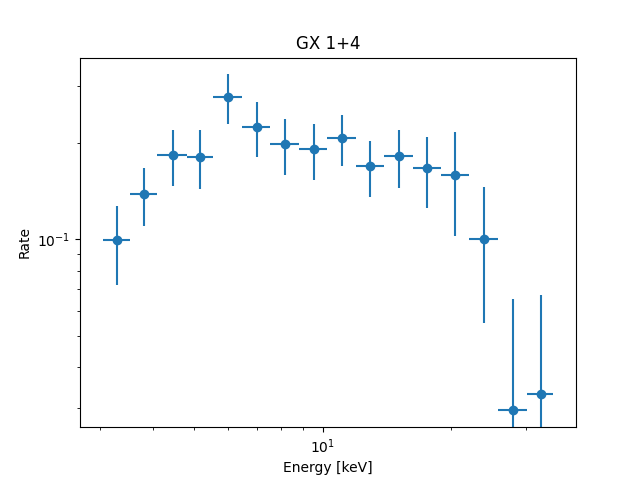

In [86]:
_=spec.show(source_name)

## We extact spectral products for ISGRI

In [93]:
par_dict = {
"DEC": "%f" % dec,
"E1_keV": e_min,
"E2_keV": e_max,
"RA": "%f" % ra,
"T1": tstart,
"T2": tstop,
"radius": radius_isgri,
"src_name": source_name,
"token": token,
"max_pointings": n_scw_spec_lc,
"instrument": "isgri",
"integral_data_rights": "public",
"off_line": "False",
"osa_version": "OSA11.1",
"product": "isgri_spectrum",
"token": token,
    "selected_catalog": catalog_string
}


In [94]:
isgri_spec = disp.get_product(**par_dict)

- waiting for remote response (since 2021-11-25 16:43:58), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
problem in API call, 19 tries left:

unable to complete API call
in <function DispatcherAPI.poll at 0x7eff57107550> called with:
... [ DispatcherAPI: https://www.astro.unige.ch/mmoda/dispatch-data ]
... 
possible causes:
- connection error
- error on the remote server
 exception message: 

HTTPSConnectionPool(host='www.astro.unige.ch', port=443): Read timed out. (read timeout=120)
Traceback (most recent call last):
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.8/http/client.py", line 1344, in getresponse
    response.begin()
  File "/u

RemoteException: RemoteException (line 77): 
unable to complete API call
in <function DispatcherAPI.poll at 0x7eff57107550> called with:
... [ DispatcherAPI: https://www.astro.unige.ch/mmoda/dispatch-data ]
... 
possible causes:
- connection error
- error on the remote server
 exception message: 

HTTPSConnectionPool(host='www.astro.unige.ch', port=443): Read timed out. (read timeout=120)
Traceback (most recent call last):
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.8/http/client.py", line 1344, in getresponse
    response.begin()
  File "/usr/lib/python3.8/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.8/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.8/ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.8/ssl.py", line 1099, in read
    return self._sslobj.read(len, buffer)
socket.timeout: The read operation timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/requests/adapters.py", line 439, in send
    resp = conn.urlopen(
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/urllib3/connectionpool.py", line 755, in urlopen
    retries = retries.increment(
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/urllib3/util/retry.py", line 532, in increment
    raise six.reraise(type(error), error, _stacktrace)
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/urllib3/packages/six.py", line 770, in reraise
    raise value
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/urllib3/connectionpool.py", line 447, in _make_request
    self._raise_timeout(err=e, url=url, timeout_value=read_timeout)
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/urllib3/connectionpool.py", line 336, in _raise_timeout
    raise ReadTimeoutError(
urllib3.exceptions.ReadTimeoutError: HTTPSConnectionPool(host='www.astro.unige.ch', port=443): Read timed out. (read timeout=120)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ferrigno/Soft/oda_api/oda_api/api.py", line 125, in func_wrapper
    return func(*args, **kwargs)
  File "/home/ferrigno/Soft/oda_api/oda_api/api.py", line 569, in poll
    self.response_json = self.request_to_json()
  File "/home/ferrigno/Soft/oda_api/oda_api/api.py", line 349, in request_to_json
    response = requests.get(
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/requests/api.py", line 75, in get
    return request('get', url, params=params, **kwargs)
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/requests/sessions.py", line 542, in request
    resp = self.send(prep, **send_kwargs)
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/requests/sessions.py", line 655, in send
    r = adapter.send(request, **kwargs)
  File "/home/ferrigno/.venv/myVE/lib/python3.8/site-packages/requests/adapters.py", line 529, in send
    raise ReadTimeout(e, request=request)
requests.exceptions.ReadTimeout: HTTPSConnectionPool(host='www.astro.unige.ch', port=443): Read timed out. (read timeout=120)


## This plots the spectram, it is possible to set limits for the energy range

In [ ]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(isgri_spec)
_ = spec.show(source_name, xlim=[20,100])

## This saves spectrum arf and response in a way to be used with xspec 
- systematic fraction adds a systematic fraction to the spectrum
- grouping performs a grouping on the spectrum the argument is [minimum_energy, maximum_energy, bins]
    - bins is the number of bin spaced logarithmically if negative, linearly if positive 

In [ ]:
import oda_api.plot_tools
reload(oda_api.plot_tools)
spec = oda_api.plot_tools.OdaSpectrum(isgri_spec)
spec.write_fits(source_name, systematic_fraction=0.01, grouping=[30,150,-20])